### Author: Murat C Koc
### Objective: Calculate Shopify Sneaker Stores AOV
### Challenge: Shopify Data Science Internship - Fall 2021

#### Question 1:
On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 

- Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 
- What metric would you report for this dataset?
- What is its value?

#### Solution:
#### Step 1:
- Check data quality, make necessary changes
#### Step 2:
- Check outliers for better analysis

In [137]:
# Libraries
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from fbprophet import Prophet

In [138]:
# Read csv into Dataframe
shoe_df = pd.read_csv('https://raw.githubusercontent.com/MuratCKoc/Fall_2021_DataScience_Intern_Challenge/main/data/shopify_sneakers.csv')
shoe_df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


#### Step 1: Check data quality

In [139]:
# Check Null values
if shoe_df.isnull().values.any() == 'False':
    print('NULL DETECTED... Dropping the Nulls')
    shoe_df = shoe_df.dropna(how='any')
else:
    print('Null check passed! No Null values Detected')

Null check passed! No Null values Detected


In [140]:
# Check duplicate entries
shoe_df.duplicated(keep='last')

0       False
1       False
2       False
3       False
4       False
        ...  
4995    False
4996    False
4997    False
4998    False
4999    False
Length: 5000, dtype: bool

In [141]:
# Check Data types
shoe_df.dtypes

order_id           int64
shop_id            int64
user_id            int64
order_amount       int64
total_items        int64
payment_method    object
created_at        object
dtype: object

In [142]:
# Convert date types -> created_at
shoe_df['created_at'] = pd.to_datetime(shoe_df['created_at'])
shoe_df.dtypes

order_id                   int64
shop_id                    int64
user_id                    int64
order_amount               int64
total_items                int64
payment_method            object
created_at        datetime64[ns]
dtype: object

#### Step 2: Explore the data

In [143]:
# Lets take a quick look at order_amounts to figure out
shoe_df.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


#### Problem:
Standard deviation is 41282 where min is only 90 and max is 70400.
Max value needs to be inspected in order to evaluate the data more accurately. Lets see how the data looks like in boxplot

<AxesSubplot:>

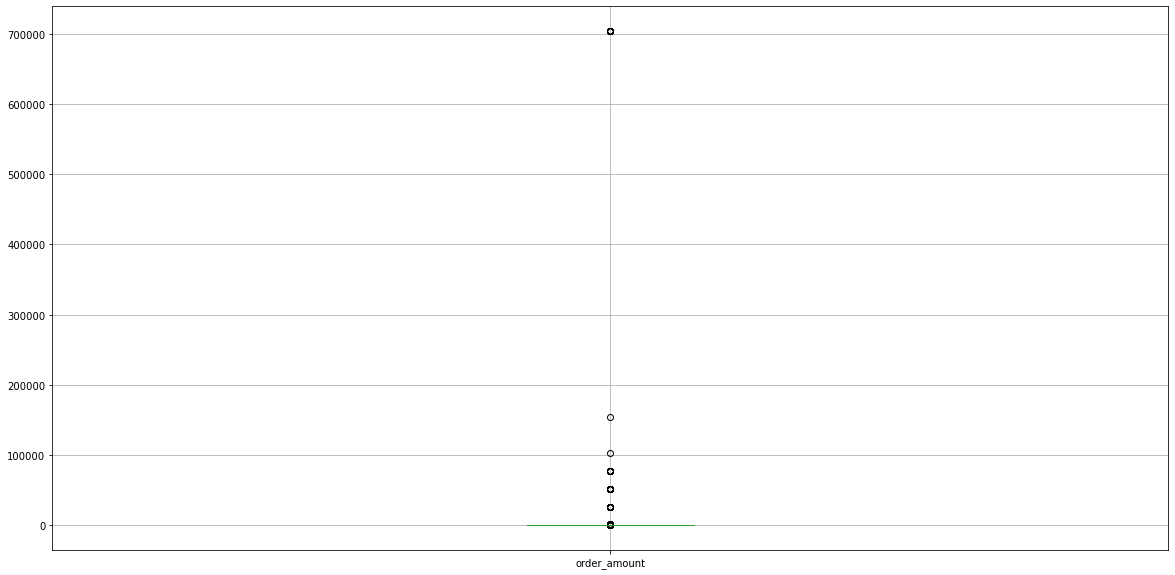

In [144]:
shoe_df.boxplot("order_amount", figsize=(20,10))

It seems like order amount $70400 is the only extreme sale in this dataset. We can calculate outliers to get a better understanding of the set.


In [145]:
shoe_df['item_price'] = shoe_df['order_amount']/shoe_df['total_items']
shoe_df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,item_price
0,1,53,746,224,2,cash,2017-03-13 12:36:56,112.0
1,2,92,925,90,1,cash,2017-03-03 17:38:52,90.0
2,3,44,861,144,1,cash,2017-03-14 04:23:56,144.0
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37,156.0
4,5,18,883,156,1,credit_card,2017-03-01 04:35:11,156.0


In [146]:
# Quantiles

In [147]:
# Determine if there are any potential outliers in average order_amount
quartiles = shoe_df['item_price'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of item price is: {lowerq}")
print(f"The upper quartile of item price is: {upperq}")
print(f"The interquartile range of item price is: {iqr}")
print(f"The the median of item price is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

outlier_order = shoe_df.loc[(shoe_df['item_price'] < lower_bound) | 
                                        (shoe_df['item_price'] > upper_bound)]
outlier_order = outlier_order.reset_index(drop=True)
outlier_order

The lower quartile of item price is: 133.0
The upper quartile of item price is: 169.0
The interquartile range of item price is: 36.0
The the median of item price is: 153.0 
Values below 79.0 could be outliers.
Values above 223.0 could be outliers.


,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,item_price
0,16,42,607,704000,2000,credit_card,2017-03-07 04:00:00,352.0
1,41,42,793,352,1,credit_card,2017-03-24 14:15:41,352.0
2,61,42,607,704000,2000,credit_card,2017-03-04 04:00:00,352.0
3,161,78,990,25725,1,credit_card,2017-03-12 05:56:57,25725.0
4,309,42,770,352,1,credit_card,2017-03-11 18:14:39,352.0
...,...,...,...,...,...,...,...,...
92,4746,42,872,352,1,debit,2017-03-24 00:57:24,352.0
93,4768,42,720,704,2,credit_card,2017-03-14 10:26:08,352.0
94,4869,42,607,704000,2000,credit_card,2017-03-22 04:00:00,352.0
95,4883,42,607,704000,2000,credit_card,2017-03-25 04:00:00,352.0


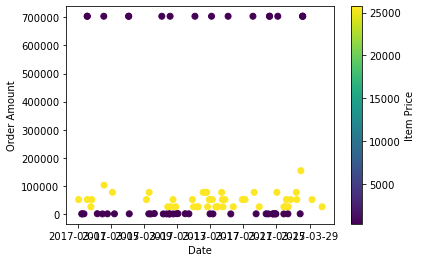

In [148]:
#outlier_shops = shoe_df.loc[(shoe_df['shop_id']=="42") | (shoe_df['shop_id']=="78")]
plt.scatter(outlier_order['created_at'],outlier_order['order_amount'],
c=outlier_order['item_price'])
clb = plt.colorbar()
plt.ylabel("Order Amount")
plt.xlabel("Date")
clb.set_label("Item Price")
plt.show()

- We have 97 outlier orders.
- 352 and 25725 orders belongs to shop 42 and 78 respectively so 78 is obviously is an outlier.
- As seen in the figure same orders entered repeatedly, so there is an issue with the shop_id 42 and 78. This issue might be an incorrect pricing, a fraud, location based mistake (foreign currency or country taxes). Therefore these store_id 78's operations must be investigated.
- Transactions of User_id 607 from shop_id seems like an automated orders timed at 04:00 am indicates a bulk orders from store 42.

In [149]:
clean_df = shoe_df.drop(shoe_df[(shoe_df.shop_id == 78)].index)
clean_df = clean_df.reset_index(drop=True)
price_index = clean_df.groupby(['shop_id']).max()['item_price'].sort_values(ascending = False)
print(price_index.head(),price_index.tail())

shop_id
42    352.0
12    201.0
89    196.0
99    195.0
50    193.0
Name: item_price, dtype: float64 shop_id
7      112.0
100    111.0
32     101.0
2       94.0
92      90.0
Name: item_price, dtype: float64


In [150]:
print(shoe_df['item_price'].describe(),clean_df['item_price'].describe())

count     5000.000000
mean       387.742800
std       2441.963725
min         90.000000
25%        133.000000
50%        153.000000
75%        169.000000
max      25725.000000
Name: item_price, dtype: float64 count    4954.000000
mean      152.475575
std        31.260218
min        90.000000
25%       132.000000
50%       153.000000
75%       168.000000
max       352.000000
Name: item_price, dtype: float64


Pricing metric and strategies vary as the numbers and these numbers seems in a good shape to get better AOV.
Deeper analytics from this dataset might include:
- Top and bottom performing stores
- Foot traffic
- Most valuable customers
- Order type categorization

In [152]:
shopify_AOV = shoe_df['order_amount'].sum() / shoe_df['order_amount'].count()
better_AOV = clean_df['order_amount'].sum() / clean_df['order_amount'].count()
print('Shopfiy AOV:',round(shopify_AOV))
print('Better AOV:',round(better_AOV))

Shopfiy AOV: 3145
Better AOV: 2717


### Question 2:
2a: How many orders were shipped by Speedy Express in total?
Answer: 54 orders shipped by Speedy Express
```sql
SELECT COUNT(ShipperName)
FROM Orders INNER JOIN Shippers ON Orders.ShipperID = Shippers.ShipperID
WHERE ShipperName = 'Speedy Express';
```

2b: What is the last name of the employee with the most orders?
Answer: Peacock
```sql
SELECT Employees.LastName, COUNT(Employees.EmployeeID as num_orders
FROM Employees INNER JOIN Orders ON EmployeeID = Employees.EmployeeID
GROUP BY LastName
ORDER BY Count(Employees.LastName) DESC
LIMIT 1;
```

2c:What product was ordered the most by customers in Germany?
Answer: 
Gorgonzola Telino
Raclette Courdavault
Mozeralla di Giovanni
```sql
SELECT ProductName FROM Products
WHERE  ProductID IN
(SELECT ProductID FROM
    (SELECT ProductID,count(*) AS Total FROM OrderDetails WHERE PRODUCTID IN
        (SELECT ProductID FROM OrderDetails WHERE OrderID IN
            (SELECT OrderID FROM Orders Where CustomerID IN
                (SELECT CustomerID FROM Customers WHERE Country = 'Germany')))
GROUP BY ProductID
```


